# Word embeddings for similarity identification  

* source: Paraphraser corpus http://paraphraser.ru/
* task: given a pair of sentences, classify them as similar or not similar

In [1]:
# Main data structures workflow
import os
import re
import numpy as np
import xml.etree.ElementTree as et
from string import punctuation
from sklearn import utils, metrics
import pandas as pd
pd.set_option('display.max_rows', 250)

# NLP libraries
import nltk
import gensim
from pymystem3 import Mystem

# Tensorflow for tensorboard viz
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
tf.logging.set_verbosity(tf.logging.ERROR)

# Visualizations
import matplotlib.pyplot as plt
from jupyter_progressbar import ProgressBar

# Corpus pickling
import pickle

# Filtering warnings
import warnings 
warnings.filterwarnings('ignore')


In [2]:
# Get paraphrase corpus in XML format

tree = et.parse('paraphrases.xml')
root = tree.getroot()

data=[]
for i in range(len(root.getchildren()[1])):
    data.append([child.text for child in root.getchildren()[1][i].getchildren()])

df = pd.DataFrame(data)
df.columns = ['id', 'id_1', 'id_2', 'text_1', 'text_2', 'jaccard', 'class']
df['jaccard'] = df['jaccard'].apply(float)
df['class'] = df['class'].apply(int)
df = df.drop(['id', 'id_1', 'id_2'], axis=1)

df.head()

,text_1,text_2,jaccard,class
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0.650000,0
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0.500000,0
2,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,0.611429,0
3,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...,0.324037,-1
4,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...,0.606218,0


* Jaccard Similarity = (Intersection of A and B) / (Union of A and B)

### Example of a paraphrase pair

In [16]:
print(df[df['class'] == 1].iloc[0][0], '\n')
print(df[df['class'] == 1].iloc[0][1], '\n')
print('-'*10)
print('Jaccard index = ', df[df['class'] == 1].iloc[0][2], '\n')

Приставы соберут отпечатки пальцев российских должников. 

Приставы снимут отпечатки пальцев у злостных неплательщиков. 

----------
Jaccard index =  0.5 



### Example of a non-paraphrase

In [19]:
print(df[df['class'] == -1].iloc[0][0], '\n')
print(df[df['class'] == -1].iloc[0][1], '\n')
print('-'*10)
print('Jaccard index = ', df[df['class'] == -1].iloc[0][2], '\n')

Вернувшихся из Сирии россиян волнует вопрос трудоустройства на родине. 

Самолеты МЧС вывезут россиян из разрушенной Сирии. 

----------
Jaccard index =  0.324037 



Classes distribution in the dataset:

* 1  =  Paraphrase
* 0  =  Partial paraphrase
* -1 =  Non-paraphrase

The corpus is labeled accordingly.

There isn't a necessity to classify all three classes. Also there is a slight class imbalance. Therefore it may be useful to even out the non-paraphrases with paraphrases with partial paraphrases.

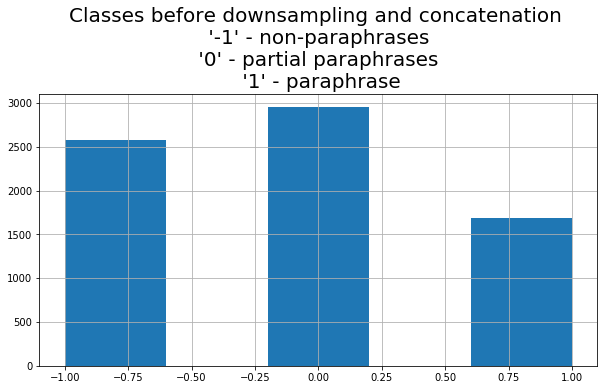

In [20]:
plt.title("Classes before downsampling and concatenation \n '-1' - non-paraphrases \n '0' - partial paraphrases \n '1' - paraphrase", size=20)
df['class'].hist(figsize=(10,5), bins=5);

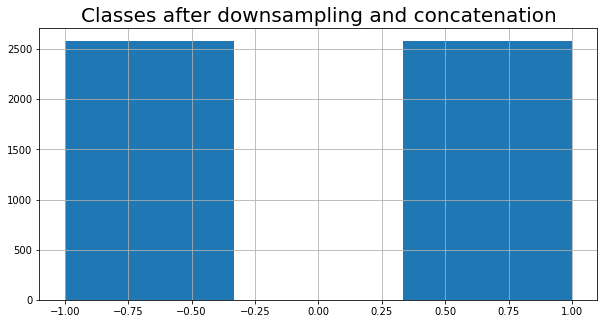

In [21]:
# downsampling

df_majority_downsampled = utils.resample(df[df['class']==0],
                                         replace=False, 
                                         n_samples=len(df[df['class']==-1])-len(df[df['class']==1]), 
                                         random_state=123)

df = pd.concat([df_majority_downsampled, pd.concat([df[df['class']==-1], df[df['class']==1]])]).dropna()

df['class'] = df['class'].apply(lambda x: 1 if x == 0 else x)

plt.title("Classes after downsampling and concatenation", size=20)
df['class'].hist(figsize=(10,5), bins=3);


The corpus is provided with a jaccard index for each pair of sentences which can be used as a good baseline for the classification task. The optimal threshold is found empirically for each approach.

In [106]:
thresholds = np.arange(0.1, 0.9, 0.01)
thresholds

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89])

In [130]:
def get_thresholds_scores(values_column, name):
    
    scores = {}
    for thr in thresholds:
        score = metrics.f1_score(df['class'], 
                                 values_column.apply(lambda x: 1 if x >= thr else -1), 
                                 average='micro')
        scores[thr] = score
    plt.figure(figsize=(10,5))
    plt.plot(scores.keys(), scores.values())
    plt.title(f'{name} best threshold search', size=20)
    plt.xlabel('classification threshold', fontsize=15)
    plt.ylabel('F1 score', fontsize=15)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.grid()
    print(f'Best F1 score: {max(scores.values())}')

Best F1 score: 0.7945391169635941


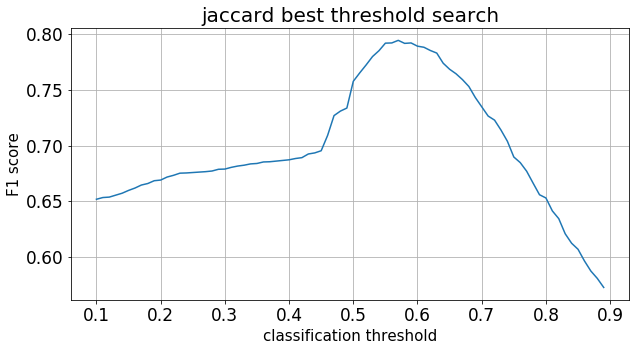

In [131]:
get_thresholds_scores(df['jaccard'], 'jaccard')

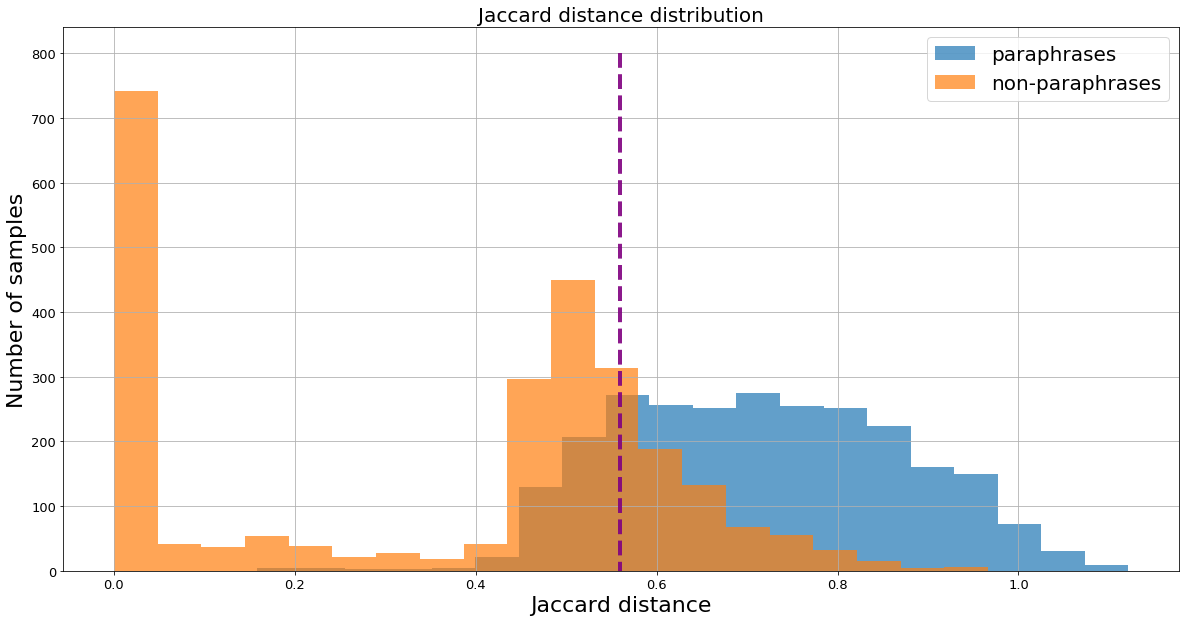

In [57]:
plt.title('Jaccard distance distribution', size=20)
plt.plot([0.56, 0.56], [800, 0], '--', lw=4, color='purple', alpha=0.9)
df['jaccard'][df['class'] == 1].hist(figsize=(20,10), alpha=0.7, bins=20, label='paraphrases')
df['jaccard'][df['class'] == -1].hist(figsize=(20,10), alpha=0.7, bins=20, label='non-paraphrases')
plt.xlabel('Jaccard distance', fontsize=22)
plt.ylabel('Number of samples', fontsize=22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(prop={'size': 20});

The F1 score for the Jaccard index baseline remained unbeated for the whole experiment flow.

In [ ]:
# testing jaccard baseline with threshold 0.6

df['jcd_pred'] = df['jaccard'].apply(lambda x: 1 if x >= 0.6 else -1)
print('F1 score for Jaccard index: ', metrics.f1_score(df['class'], df['jcd_pred'], average='micro'))

To fit the embeddings the Lenta news corpus from Taiga is used. 
* Size = 5 million words
* Number of documents = 36.5k 

A classic preprocessing pipeline is utilized, removing non cyrillic words, numbers, punctuation and tokens less that 2 characters long

In [149]:
mystem = Mystem() 
russian_stopwords = nltk.corpus.stopwords.words("russian")

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
                                        and token != " " \
                                        and token.strip() not in punctuation \
                                        and bool(re.search('[а-яА-Я]', token)) \
                                        and len(token) > 2 \
                                        and not any(c.isdigit() for c in token)]
    return tokens


In [151]:
lenta_corpus = [preprocess_text(open(f'texts/{text}').read()) for text in ProgressBar(os.listdir('texts/'))]

In [152]:
# save preprocessed corpus
with open('lenta_corpus_preprocessed', 'wb') as f:
     pickle.dump(lenta_corpus, f)


# load preprocessed corpus
# with open('lenta_corpus_preprocessed', 'rb') as f:
#    lenta_corpus = pickle.load(f)
    

In [179]:
print(lenta_corpus[1])

['телеобращение', 'украинский', 'народ', 'который', 'февраль', 'планировать', 'выступать', 'премьер-министр', 'страна', 'юлия', 'тимошенко', 'состояться', 'сообщать', 'украинский', 'правда', 'раскрывать', 'свой', 'источник', 'также', 'отменять', 'заседание', 'кабинет', 'министр', 'крайний', 'мера', 'оно', 'анонсировать', 'сайт', 'правительство', 'телефон', 'аккредитация', 'украинский', 'кабмин', 'отвечать', 'молчать', 'телефон', 'пресс-секретарь', 'тимошенко', 'марина', 'сорока', 'отмечать', 'украинский', 'правда', 'украинский', 'министр', 'петр', 'крупко', 'заявлять', 'заседание', 'правительство', 'перенести', 'февраль', 'связывать', 'это', 'участие', 'тимошенко', 'член', 'кабмин', 'церемония', 'похороны', 'гендиректор', 'государственный', 'предприятие', 'запорожский', 'машиностроительный', 'конструкторский', 'бюро', 'ивченко', 'прогресс', 'федор', 'муравченко', 'ранее', 'тимошенко', 'планировать', 'февраль', 'проводить', 'пресс-конференция', 'однако', 'отменять', 'взамен', 'назначать

In [154]:
# getting Word2Vec embeddings

w2v_lenta = gensim.models.Word2Vec(lenta_corpus, size=100, window=5, min_count=5, workers=4)

In [155]:
d2v_train_data = []
for i in range(len(lenta_corpus)):
    d2v_train_data.append(gensim.models.doc2vec.TaggedDocument(lenta_corpus[i], [i]))

In [156]:
d2v_train_data[2]

TaggedDocument(words=['учитель', 'физкультура', 'белорусский', 'школа', 'накормить', 'учащийся', 'психотропный', 'препарат', 'это', 'сообщать', 'белт', 'происходить', 'свислочский', 'район', 'гродненский', 'область', 'учитель', 'выясняться', 'обнаруживать', 'кабинет', 'индивидуальный', 'аптечка', 'который', 'следовать', 'сдавать', 'склад', 'штаб', 'гражданский', 'оборона', 'уничтожение', 'находить', 'аптечка', 'таблетка', 'маркировка', 'тарен', 'физрук', 'предлагать', 'школьник', 'информация', 'агентство', 'рекламировать', 'ребенок', 'лекарство', 'вызывать', 'состояние', 'кайф', 'галлюциноген', 'учитель', 'время', 'находиться', 'состояние', 'алкогольный', 'опьянение', 'пробовать', 'таблетка', 'неизвестно', 'ребенок', 'попробовать', 'таблетка', 'сообщаться', 'вести', 'неадекватно', 'бредить', 'впоследствии', 'лекарство', 'отдавать', 'экспертиза', 'выясняться', 'содержаться', 'апрофный', 'который', 'белоруссия', 'относить', 'число', 'опасный', 'психотропный', 'вещество', 'учитель', 'связ

In [157]:
# getting Doc2Vec embeddings

d2v_lenta = gensim.models.Doc2Vec(d2v_train_data, size=100, window=5, min_count=5, workers=4)

In [158]:
d2v_lenta.most_similar('экспертиза')

[('судебно-медицинский', 0.7711539268493652),
 ('судмедэкспертиза', 0.7208194136619568),
 ('осмотр', 0.7171461582183838),
 ('дактилоскопический', 0.7073444724082947),
 ('вскрытие', 0.6972476243972778),
 ('опознание', 0.6952383518218994),
 ('обследование', 0.6926261186599731),
 ('анализ', 0.6861236095428467),
 ('проверка', 0.670927882194519),
 ('освидетельствование', 0.6691159009933472)]

In [159]:
# getting FastText embeddings

fasttext_lenta = gensim.models.FastText(lenta_corpus, size=100, window=5, min_count=5, workers=4)

The preprocessing pipeline is applied to the pairs of sentences in the paraphrasing dataframe

In [160]:
df['text_1'] = df['text_1'].apply(preprocess_text)
df['text_2'] = df['text_2'].apply(preprocess_text)

# removing tokens which are not found in the embedding vocabulary
df['text_1'] = df['text_1'].apply(lambda tokens: [token for token in tokens if token in d2v_lenta.wv.vocab.keys()])
df['text_2'] = df['text_2'].apply(lambda tokens: [token for token in tokens if token in d2v_lenta.wv.vocab.keys()])

Sentence level similarity check is implemented in the Doc2Vec class 

In [161]:
def d2v_similarity(row):
    try:
        return d2v_lenta.n_similarity(row[0], row[1])
    except:
        return row[3]

In [162]:
df['doc2vec'] = df.apply(d2v_similarity, axis=1)

Best F1 score: 0.7077846630518979


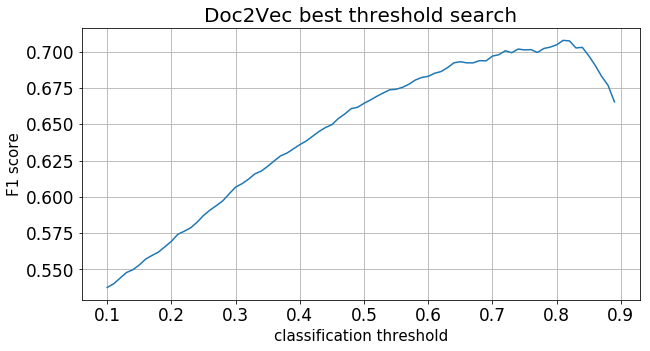

In [163]:
get_thresholds_scores(df['doc2vec'], 'Doc2Vec')

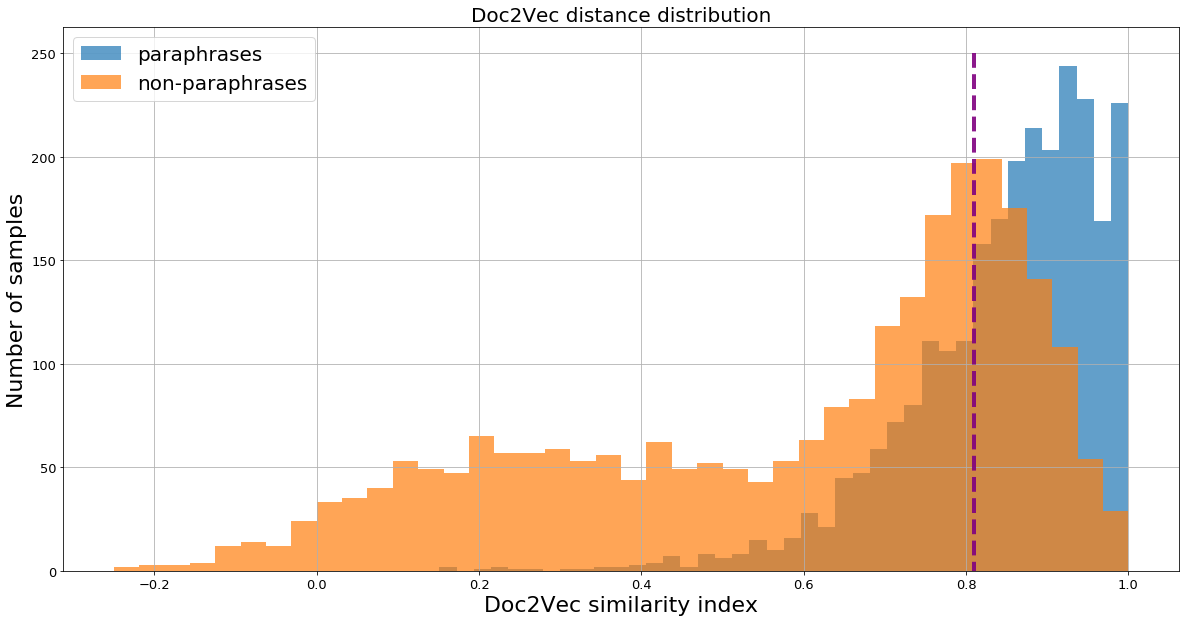

In [165]:
plt.title('Doc2Vec distance distribution', size=20)
plt.plot([0.81, 0.81], [250, 0], '--', lw=4, color='purple', alpha=0.9)
df['doc2vec'][df['class'] == 1].hist(figsize=(20,10), alpha=0.7, bins=40, label='paraphrases')
df['doc2vec'][df['class'] == -1].hist(figsize=(20,10), range=(-0.25, 1), alpha=0.7, bins=40, label='non-paraphrases')
plt.xlabel('Doc2Vec similarity index', fontsize=22)
plt.ylabel('Number of samples', fontsize=22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(prop={'size': 20});

The Word2Vec similarity check needed to be implemented manually. For this purpose the average vector value is calculated for each sentence and then compared using cosine similarity formula.

In [166]:
def sim_score(series, model):
    wordlist1 = series[0]
    wordlist2 = series[1]
    maxes = []
    for word in wordlist1:
        cur_max = 0
        for word2 in wordlist2:
            if word == word2: #case where words are identical
                sim = 1
                cur_max = sim
            elif word in model.wv.vocab.keys() and word2 in model.wv.vocab.keys():
                sim = model.similarity(word, word2) #calculate cosine similarity score for words
                if sim > cur_max:
                    cur_max = sim
        if cur_max != 0:
            maxes.append(cur_max)
    if sum(maxes) == 0:
        return 0
    else:
        return float(sum(maxes)) / len(maxes)

In [167]:
df['word2vec'] = df[['text_1', 'text_2']].apply(sim_score, model=w2v_lenta, axis=1)

Best F1 score: 0.7687838884585593


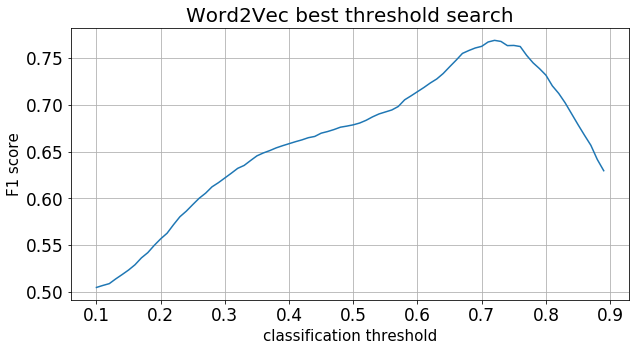

In [168]:
get_thresholds_scores(df['word2vec'], 'Word2Vec')

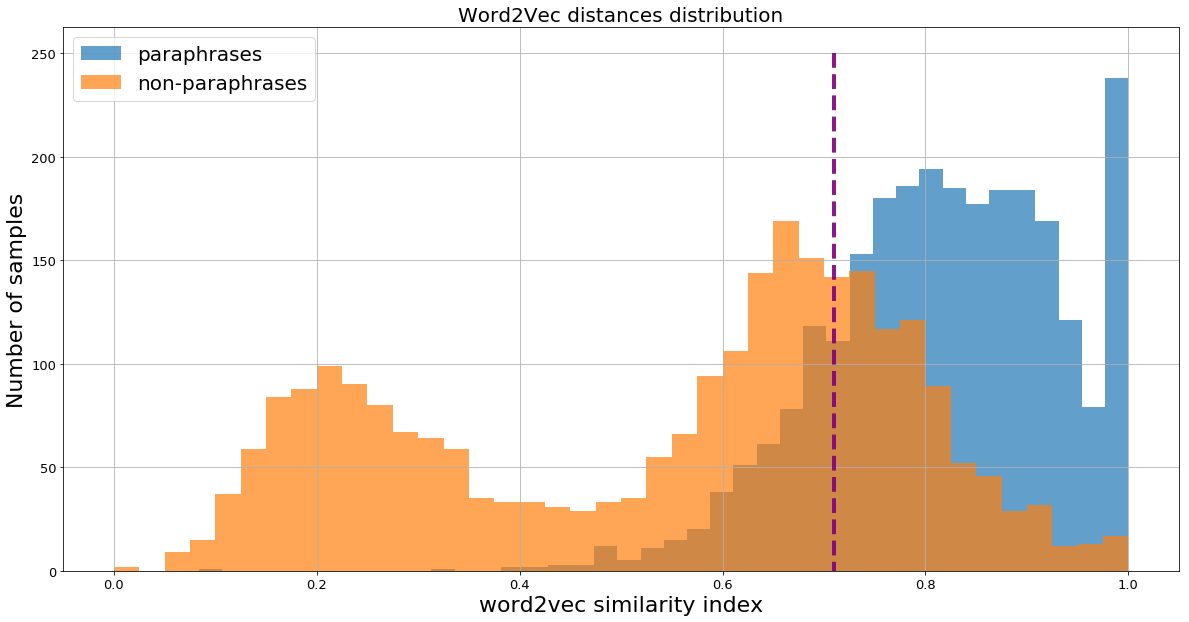

In [169]:
plt.title('Word2Vec distances distribution', size=20)
plt.plot([0.71, 0.71], [250, 0], '--', lw=4, color='purple', alpha=0.9)
df['word2vec'][df['class'] == 1].hist(figsize=(20,10), alpha=0.7, bins=40, label='paraphrases')
df['word2vec'][df['class'] == -1].hist(figsize=(20,10), alpha=0.7, bins=40, label='non-paraphrases')
plt.xlabel('word2vec similarity index', fontsize=22)
plt.ylabel('Number of samples', fontsize=22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(prop={'size': 20});

In [170]:
df['fasttext'] = df[['text_1', 'text_2']].apply(sim_score, model=fasttext_lenta, axis=1)

Best F1 score: 0.7558094500387297


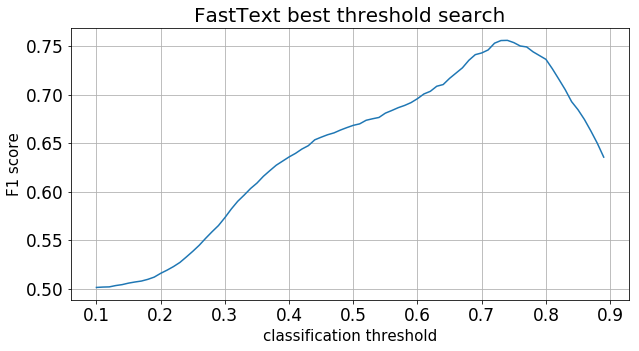

In [171]:
get_thresholds_scores(df['fasttext'], 'FastText')

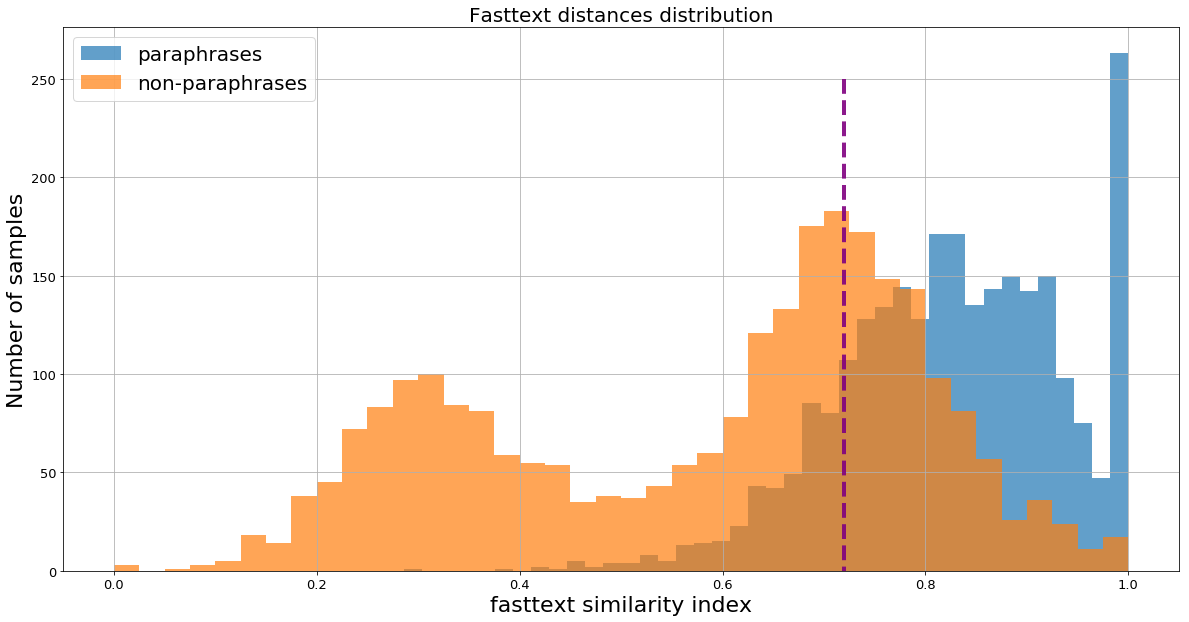

In [172]:
plt.title('Fasttext distances distribution', size=20)
plt.plot([0.72, 0.72], [250, 0], '--', lw=4, color='purple', alpha=0.9)
df['fasttext'][df['class'] == 1].hist(figsize=(20,10), alpha=0.7, bins=40, label='paraphrases')
df['fasttext'][df['class'] == -1].hist(figsize=(20,10), alpha=0.7, bins=40, label='non-paraphrases')
plt.xlabel('fasttext similarity index', fontsize=22)
plt.ylabel('Number of samples', fontsize=22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(prop={'size': 20});

The best result (apart from the Jaccard index baseline) is derived from Word2Vec embedding method. 

Pretrained FastText embeddings from https://github.com/Kyubyong/wordvectors have also been checked in the same fashion

In [173]:
pretrained_ft = gensim.models.fasttext.load_facebook_model('ru.bin', encoding='utf-8')

In [174]:
df['fasttext_pretrained'] = df[['text_1', 'text_2']].apply(sim_score, model=pretrained_ft, axis=1)

Best F1 score: 0.750580945003873


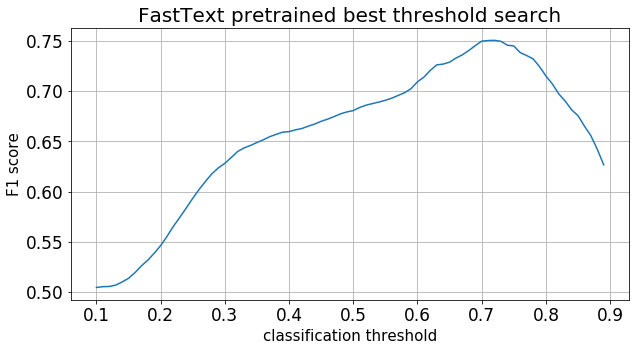

In [175]:
get_thresholds_scores(df['fasttext_pretrained'], 'FastText pretrained')

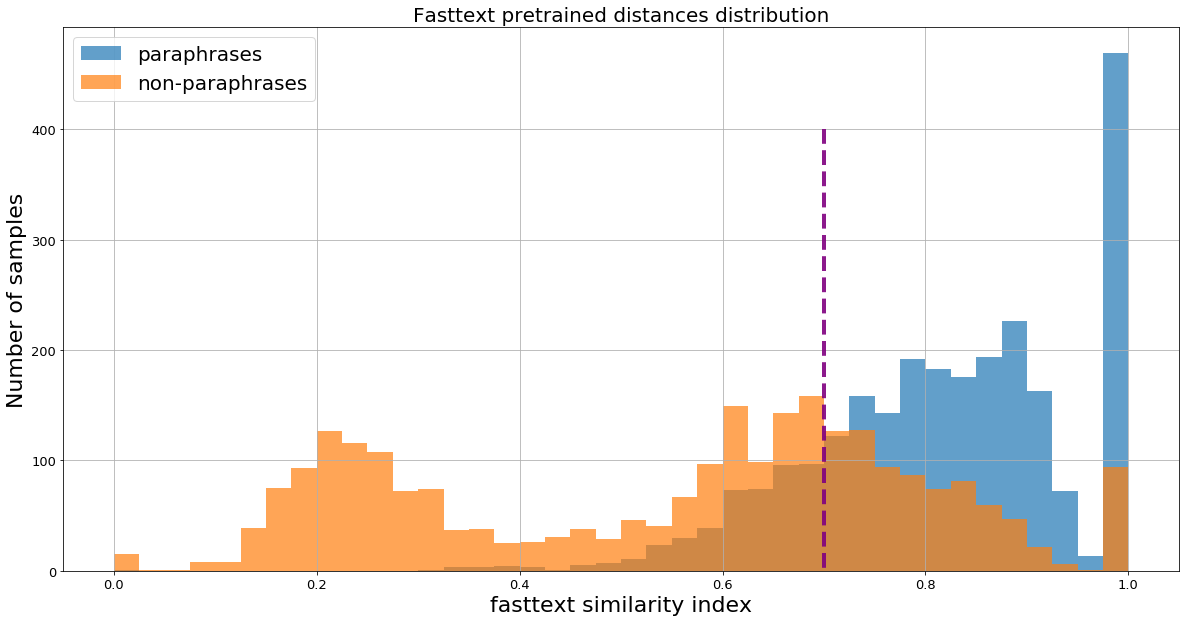

In [176]:
plt.title('Fasttext pretrained distances distribution', size=20)
plt.plot([0.7, 0.7], [400, 0], '--', lw=4, color='purple', alpha=0.9)
df['fasttext_pretrained'][df['class'] == 1].hist(figsize=(20,10), alpha=0.7, bins=40, label='paraphrases')
df['fasttext_pretrained'][df['class'] == -1].hist(figsize=(20,10), alpha=0.7, bins=40, label='non-paraphrases')
plt.xlabel('fasttext similarity index', fontsize=22)
plt.ylabel('Number of samples', fontsize=22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(prop={'size': 20});

## Visualizing embeddings using tensorboard

In [178]:
w2v_lenta.wv.save_word2vec_format('w2v_lenta_model')


max_size = len(w2v_lenta.wv.vocab)-1
w2v = np.zeros((max_size,w2v_lenta.layer1_size))

try:
    os.makedirs('projections')
except FileExistsError:
    print('File exists')


with open("projections/metadata.tsv", 'w+') as file_metadata:
    
    for i, word in enumerate(w2v_lenta.wv.index2word[:max_size]):
        
        #store the embeddings of the word
        w2v[i] = w2v_lenta.wv[word]
        
        #write the word to a file 
        file_metadata.write(word + '\n')

sess = tf.InteractiveSession()

with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v, trainable=False, name='embedding')
tf.global_variables_initializer().run()

saver = tf.train.Saver()
writer = tf.summary.FileWriter('projections', sess.graph)
config = projector.ProjectorConfig()

embed= config.embeddings.add()

embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(writer, config)

saver.save(sess, 'projections/model.ckpt', global_step=max_size)

File exists


'projections/model.ckpt-34810'

In [ ]:
# tensorboard --logdir=projections --port=8000